<a href="https://colab.research.google.com/github/Leo-Rola/Advanced-Machine-Learning-2022-2023/blob/main/Project_Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip install -U pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.3.1 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1)
ERROR: No matching distribution found for torch==1.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 26.4 MB/s 
     |████████████████████████████████| 753.4 MB 20 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0+cu116
    Uninstalling torchvision-0.14.0+cu116:
      Successfully uninstalled torchvision-0.14.0+cu116
ERROR: pip's dependency resolver does not c

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 20.4 MB/s 
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.4.0 which is incompatible.
fastai 2.7.10 requires torchvision>=0.8.2, but you have torchvision 0.5.0 which is incompatible.


**Import libraries**

In [ ]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt 
from statistics import mean 
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torch.autograd import Variable
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import alexnet, vgg16, resnet18, resnet50

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [ ]:

DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 100    

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.1      # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001  # Regularization, you can keep this at the default

NUM_EPOCHS = 160   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 25


**Define Data Preprocessing**

In [ ]:
PRE_TRAINED = False     # set to True to load the pre-trained AlexNet

NETWORK_TYPE = "resnet20"       #define which network we will use:
                              #alexnet, vgg, resnet

FREEZING = "no_freezing"        # define which layers of the network will be kept frozen
                                # None : train the whole network
                                # "CONV" : train only the FC-layers
                                # "FC" : train only the conv-layers

AUG_PROB = 0.5   # the probability with witch each image is transformed at training time during each epoch
AUG_TYPE = "RC-RHF"         # define the type of augmentation pipeline 
                            # None for no data augmentation
                            # "CS-HF" for contrast + saturation + horizontal flip
                            # "H-RP" for hue + random perspective
                            # "B-GS-R" for brightness + grayscale + rotation
                            # "RC-RHF" random crop + random horizontal flip => for the project

**Trasformations**

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split

if PRE_TRAINED:
  normalizer = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
else:
  normalizer = transforms.Normalize(mean = (0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761))

# Define transforms for training phase
train_transform = transforms.Compose([transforms.ToTensor()])

# Define transforms for the evaluation phase
test_transform = transforms.Compose([transforms.ToTensor()])

bright_t = transforms.ColorJitter(brightness=[1,2])
contrast_t = transforms.ColorJitter(contrast = [2,5])
saturation_t = transforms.ColorJitter(saturation = [1,3])
hue_t = transforms.ColorJitter(hue = 0.2)
gs_t = transforms.Grayscale(3)
rp_t = transforms.RandomPerspective(p = 1, distortion_scale = 0.5)
rot_t = transforms.RandomRotation(degrees = 90)
rand_crop = transforms.RandomCrop(32, padding = 4)
hflip_t = transforms.RandomHorizontalFlip(p = 1)

aug_transformations = {
    "CS-HF": transforms.Compose([contrast_t, saturation_t, hflip_t]),
    "H-RP": transforms.Compose([hue_t, rp_t]),
    "B-GS-R": transforms.Compose([bright_t, gs_t, rot_t]),
    "RC-RHF": transforms.Compose([rand_crop, hflip_t])
    }

if AUG_TYPE is not None:
  aug_transformation = aug_transformations[AUG_TYPE]
  aug_pipeline = transforms.Compose([ 
                                      transforms.ToPILImage(),
                                      transforms.RandomApply([aug_transformation], p = AUG_PROB),
                                      transforms.ToTensor(),
                                      normalizer
                                     ])
else:
  aug_pipeline = normalizer


**Define Training set, validation set and testing**



In [ ]:

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=test_transform)
classes = trainset.classes
class_count = {}
for _, index in trainset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)
print(f"classi totali: {len(class_count)}")

val_size = 5000
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])



trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, drop_last=True)

validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, drop_last=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2, drop_last=True)

# Check dataset sizes
print('Train Dataset: {}'.format(len(trainset)))
print('Valid Dataset: {}'.format(len(validset)))
print('Test Dataset: {}'.format(len(testset)))


0it [00:00, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
{'cattle': 500, 'dinosaur': 500, 'apple': 500, 'boy': 500, 'aquarium_fish': 500, 'telephone': 500, 'train': 500, 'cup': 500, 'cloud': 500, 'elephant': 500, 'keyboard': 500, 'willow_tree': 500, 'sunflower': 500, 'castle': 500, 'sea': 500, 'bicycle': 500, 'wolf': 500, 'squirrel': 500, 'shrew': 500, 'pine_tree': 500, 'rose': 500, 'television': 500, 'table': 500, 'possum': 500, 'oak_tree': 500, 'leopard': 500, 'maple_tree': 500, 'rabbit': 500, 'chimpanzee': 500, 'clock': 500, 'streetcar': 500, 'cockroach': 500, 'snake': 500, 'lobster': 500, 'mountain': 500, 'palm_tree': 500, 'skyscraper': 500, 'tractor': 500, 'shark': 500, 'butterfly': 500, 'bottle': 500, 'bee': 500, 'chair': 500, 'woman': 500, 'hamster': 500, 'otter': 500, 'seal': 500, 'lion': 500, 'mushroom': 500, 'girl': 500, 'sweet_pepper': 500, 'forest': 500, 'crocodile': 500, 'orange': 500, 'tulip': 500, 'mouse': 500, 'camel': 500, 'caterpillar'

**Show immages and classes of the dataset**

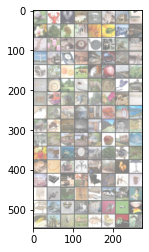

snail lobster cup   trout bowl  mouse house snake orchid pine_tree porcupine elephant sunflower sweet_pepper mountain train lizard rose  otter clock plate train shrew couch rocket bus   clock lobster streetcar lamp  otter kangaroo chair squirrel orange cattle squirrel apple road  forest mouse bowl  willow_tree cockroach fox   snake telephone tank  telephone bus   raccoon crocodile willow_tree orchid camel cloud mouse kangaroo crocodile lamp  television lobster clock mountain elephant shrew television cloud wardrobe road  man   willow_tree bridge rabbit streetcar bridge aquarium_fish apple train ray   sweet_pepper fox   turtle clock house oak_tree turtle shrew beaver worm  tractor lamp  tank  tractor pear  lamp  streetcar chair kangaroo worm  chair raccoon lizard cup   lamp  motorcycle wolf  kangaroo couch bus   house girl  chair pine_tree bowl  cattle leopard otter skunk bowl  aquarium_fish palm_tree spider tiger trout chair mouse squirrel


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image (maybe to change the unnormalize part)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))


**Build resNet20**

In [ ]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='B'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #self.bn1 = nn.BatchNorm2d(planes)
        # GroupNorm takes number of groups to divide the
        # channels in and the number of channels to expect
        # in the input
        self.bn1 = nn.GroupNorm(4, planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn2 = nn.BatchNorm2d(planes)
        self.bn2 = nn.GroupNorm(4, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                  #nn.BatchNorm2d(self.expansion * planes)
                  nn.GroupNorm(4, self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        #self.bn1 = nn.BatchNorm2d(16)
        self.bn1 = nn.GroupNorm(4, 16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

**Prepare Network**

In [ ]:

if NETWORK_TYPE == 'alexnet':
  net = alexnet(pretrained=PRE_TRAINED) # Loading AlexNet model, if pretrained = True, returns a model pre-trained on ImageNet
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

# OTHER NETWORKS ------------------------------------------------------------------------------------------
elif NETWORK_TYPE == 'vgg':
  net = vgg16(pretrained='imagenet')
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

elif NETWORK_TYPE == 'resnet20':  
  print("resnet20")
  net = resnet20()  
  print(net) #show details of resnet20

elif NETWORK_TYPE == 'resnet18':  
  net = resnet18()  
  print(net) #show details of resnet18


resnet20
ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): GroupNorm(4, 16, eps=1e-05, affine=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(4, 16, eps=1e-05, affine=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(4, 16, eps=1e-05, affine=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(4, 16, eps=1e-05, affine=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(4, 16, eps=1e-05, affine=True)
      (shortcut): Sequential()
    )
    (2): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize and which one to freeze
if (FREEZING == 'no_freezing'):
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif (FREEZING == 'conv_layers'):
  parameters_to_optimize = net.classifier.parameters() # Updates only fully-connected layers (no conv)
elif (FREEZING == 'fc_layers'):
  parameters_to_optimize = net.features.parameters() # Updates only conv layers (no fc)
else :
  raise (ValueError(f"Error Freezing layers (FREEZE = {FREEZING}) \n Possible values are: 'no_freezing', 'conv_layers', 'fc_layers' "))

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
#parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, STEP_SIZE)

**Validation**

In [ ]:

def evaluate(net, dataloader, print_tqdm = True):
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable: 
      norm_images = []
      for image in images:
        norm_image = normalizer(image)
        norm_images.append(norm_image)
      norm_images = torch.stack(norm_images)  
      norm_images = norm_images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(norm_images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))

  return accuracy, mean(losses)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in trainloader:
    aug_images = []

    for image in images:
      aug_image = aug_pipeline(image) 
      aug_images.append(aug_image) 

    aug_images = torch.stack(aug_images)

    # Bring data over the device of choice
    aug_images = aug_images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(aug_images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  train_acc, train_loss = evaluate(net, trainloader, print_tqdm = False)
  train_accuracies.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss = evaluate(net, validloader, print_tqdm = False)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)

  # Step the scheduler
  scheduler.step() 

Starting epoch 1/160, LR = [0.1]
Step 0, Loss 0.9887531399726868
Step 25, Loss 0.9022598266601562
Step 50, Loss 1.055271863937378
Step 75, Loss 0.9860667586326599
Step 100, Loss 1.1943007707595825
Step 125, Loss 1.0141534805297852
Step 150, Loss 0.9811398386955261
Step 175, Loss 0.8951401114463806
Step 200, Loss 1.1222681999206543
Step 225, Loss 1.0898932218551636
Step 250, Loss 1.3591827154159546
Step 275, Loss 1.333266019821167
Step 300, Loss 0.9941538572311401
Step 325, Loss 0.9252023100852966
Step 350, Loss 1.1796408891677856
Starting epoch 2/160, LR = [0.0993844170297569]
Step 375, Loss 1.1976534128189087
Step 400, Loss 1.2758641242980957
Step 425, Loss 0.86395263671875
Step 450, Loss 0.9280703067779541
Step 475, Loss 1.0091241598129272
Step 500, Loss 1.0004760026931763
Step 525, Loss 0.9380245208740234
Step 550, Loss 1.1130343675613403
Step 575, Loss 1.1612790822982788
Step 600, Loss 0.8905528783798218
Step 625, Loss 0.8761699199676514
Step 650, Loss 1.1740734577178955
Step 675, 

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
print("Best accuracies on the validation set: ", val_acc)

results_df = pd.DataFrame(zip(range(1,NUM_EPOCHS+1), train_accuracies, val_accuracies, train_losses, val_losses), columns = ["epoch", "train_accuracy", "val_accuracy", "train_loss", "val_loss"])
results_df.set_index("epoch")
results_df.plot(x = "epoch", y = ["train_accuracy", "val_accuracy"])
results_df.plot(x = "epoch", y = ["train_loss", "val_loss"])

NameError: ignored

**Test**

In [ ]:

accuracy = evaluate(net, testloader)[0]
print('\nTest Accuracy: {}'.format(accuracy))

100%|██████████| 78/78 [00:02<00:00, 35.66it/s]


Test Accuracy: 0.5796
